# Supervised topic analysis using multilabel classification

## Introduction

Binary classifiers seek to predict a single optimal label for each feature vector. Typically, the values 0 or 1 are used to represent the label, although other schemes, such as True/False can be used.

A multilabel classifier seeks to predict the optimal labels for each feature vector where the target is no longer a single value, as with a binary classifier, but a vector of binary labels.  For example, consider the problem of classifying images that can contain any of the letters A, B and C. The classifier is trained to recognise the letters and when shown an image with the letters A and C it should predict the labels to be $[1, 0, 1]$.

This Jupyter notebook explores the problem of predicting the topics present in a corpus where training data exists as to which topics are present in a given document. A single document can contain words from zero or more topics. This is different from unsupervised topic analysis in that the topics have been defined and the topics present in a document are available, thus a supervised approach can be used. For simplicity, this notebook generates random text data and then different multilabel classification techniques are explored. This allows the relative proportions of the topics present in the texts to be changed and the effect on performance to be measured. The texts generated are not human readable because the generative model is simplistic, but it is sufficient for testing and demonstrating a multilabel classification solution.

## Data generation

Each document is generated using a mixture model. There are three primary components:

* Stop words -- high frequency words such as 'a', 'the', 'see'.
* Common words -- common English words that are not stop words, such as 'matter', 'found', 'create'.
* Topic words -- words derived from a given topic.

This work assumes that there are at least two topics of interest. In the code below, three random topics were defined: 'vehicle'; 'internet'; and 'garden'. The topics were chosen because they don't contain overlapping words.

The number of stop words in a text $N_{stop}$ is determined by sampling from a Poisson distribution with mean $\lambda_{stop}$. The number of stop words $N_{stop}$ required for the text are then sampled by randomly selecting stop words (with replacement), which are contained in a pre-defined set.

Similarly, the number of common words in a text is determined by sampling from a Poisson distribution with mean $\lambda_{common}$. $N_{common}$ words are randomly sampled with replacement from the set of all common words.

The text can contain words from zero or more topics. The probability that topic $i$ appears in a text is denoted $p_i$ where $0 \leq p_i \leq 1$. The presence of the topic in a text is determined by sampling from a Bernoulli distribution with $p_i$. If a topic exists, the number of words randomly selected from the topic (with replacement) is determined by sampling from a Poisson distribution with mean $\lambda_i$ where $\lambda_i > 0$.

In the model decribed, the topics of interest are independent.

### Word lists

Stop words are commonly occurring words that are essentially 'noise'.

In [1]:
# Stop words
stop_words = ['a', 'about', 'above', 'across', 'after', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'among', 'an', 'and', 'another', 'any', 'anybody', 'anyone', 'anything', 'anywhere', 'are', 'area', 'areas', 'around', 'as', 'ask', 'asked', 'asking', 'asks', 'at', 'away', 'b', 'back', 'backed', 'backing', 'backs', 'be', 'became', 'because', 'become', 'becomes', 'been', 'before', 'began', 'behind', 'being', 'beings', 'best', 'better', 'between', 'big', 'both', 'but', 'by', 'c', 'came', 'can', 'cannot', 'case', 'cases', 'certain', 'certainly', 'clear', 'clearly', 'come', 'could', 'd', 'did', 'differ', 'different', 'differently', 'do', 'does', 'done', 'down', 'down', 'downed', 'downing', 'downs', 'during', 'e', 'each', 'early', 'either', 'end', 'ended', 'ending', 'ends', 'enough', 'even', 'evenly', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'f', 'face', 'faces', 'fact', 'facts', 'far', 'felt', 'few', 'find', 'finds', 'first', 'for', 'four', 'from', 'full', 'fully', 'further', 'furthered', 'furthering', 'furthers', 'g', 'gave', 'general', 'generally', 'get', 'gets', 'give', 'given', 'gives', 'go', 'going', 'good', 'goods', 'got', 'great', 'greater', 'greatest', 'group', 'grouped', 'grouping', 'groups', 'h', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'herself', 'high', 'high', 'high', 'higher', 'highest', 'him', 'himself', 'his', 'how', 'however', 'i', 'if', 'important', 'in', 'interest', 'interested', 'interesting', 'interests', 'into', 'is', 'it', 'its', 'itself', 'j', 'just', 'k', 'keep', 'keeps', 'kind', 'knew', 'know', 'known', 'knows', 'l', 'large', 'largely', 'last', 'later', 'latest', 'least', 'less', 'let', 'lets', 'like', 'likely', 'long', 'longer', 'longest', 'm', 'made', 'make', 'making', 'man', 'many', 'may', 'me', 'member', 'members', 'men', 'might', 'more', 'most', 'mostly', 'mr', 'mrs', 'much', 'must', 'my', 'myself', 'n', 'necessary', 'need', 'needed', 'needing', 'needs', 'never', 'new', 'new', 'newer', 'newest', 'next', 'no', 'nobody', 'non', 'noone', 'not', 'nothing', 'now', 'nowhere', 'number', 'numbers', 'o', 'of', 'off', 'often', 'old', 'older', 'oldest', 'on', 'once', 'one', 'only', 'open', 'opened', 'opening', 'opens', 'or', 'order', 'ordered', 'ordering', 'orders', 'other', 'others', 'our', 'out', 'over', 'p', 'part', 'parted', 'parting', 'parts', 'per', 'perhaps', 'place', 'places', 'point', 'pointed', 'pointing', 'points', 'possible', 'present', 'presented', 'presenting', 'presents', 'problem', 'problems', 'put', 'puts', 'q', 'quite', 'r', 'rather', 'really', 'right', 'right', 'room', 'rooms', 's', 'said', 'same', 'saw', 'say', 'says', 'second', 'seconds', 'see', 'seem', 'seemed', 'seeming', 'seems', 'sees', 'several', 'shall', 'she', 'should', 'show', 'showed', 'showing', 'shows', 'side', 'sides', 'since', 'small', 'smaller', 'smallest', 'so', 'some', 'somebody', 'someone', 'something', 'somewhere', 'state', 'states', 'still', 'still', 'such', 'sure', 't', 'take', 'taken', 'than', 'that', 'the', 'their', 'them', 'then', 'there', 'therefore', 'these', 'they', 'thing', 'things', 'think', 'thinks', 'this', 'those', 'though', 'thought', 'thoughts', 'three', 'through', 'thus', 'to', 'today', 'together', 'too', 'took', 'toward', 'turn', 'turned', 'turning', 'turns', 'two', 'u', 'under', 'until', 'up', 'upon', 'us', 'use', 'used', 'uses', 'v', 'very', 'w', 'want', 'wanted', 'wanting', 'wants', 'was', 'way', 'ways', 'we', 'well', 'wells', 'went', 'were', 'what', 'when', 'where', 'whether', 'which', 'while', 'who', 'whole', 'whose', 'why', 'will', 'with', 'within', 'without', 'work', 'worked', 'working', 'works', 'would', 'x', 'y', 'year', 'years', 'yet', 'you', 'young', 'younger', 'youngest', 'your', 'yours', 'z']
stop_words = set(stop_words)
print(len(stop_words))

423


Common words occur frequently, but not so frequently as to be deemed stop words.

In [2]:
# Common words (non-stop words) derived from https://gist.github.com/deekayen/4148741
common_words = {'charge', 'view', 'morning', 'especially', 'care', 'happy', 'wrote', 'occur', 'final', 'women', 'offer', 'rain', 'clean', 'nine', 'blow', 'excite', 'shape', 'teach', 'floor', 'black', 'copy', 'car', 'drink', 'quotient', 'practice', 'animal', 'grow', 'proper', 'believe', 'huge', 'segment', 'answer', 'begin', 'force', 'region', 'drive', 'contain', 'house', 'girl', 'board', 'coat', 'clothe', 'energy', 'visit', 'common', 'arrive', 'correct', 'difficult', 'color', 'song', 'person', 'dark', 'exercise', 'flower', 'caught', 'throw', 'anger', 'safe', 'spoke', "won't", 'head', 'paper', 'leave', 'neck', 'captain', 'except', 'trade', 'children', 'insect', 'mean', 'field', 'smile', 'voice', 'experience', 'sharp', 'protect', 'store', 'run', 'degree', 'flow', 'control', 'record', 'main', 'syllable', 'left', 'moment', 'ready', 'born', 'table', 'rest', 'winter', 'million', 'string', 'picture', 'example', 'sail', 'party', 'stand', 'true', 'boy', 'beauty', 'front', 'solution', 'cold', 'jump', 'soon', 'triangle', 'study', 'plan', 'special', 'fine', 'appear', 'position', 'type', 'truck', 'tree', 'fall', 'mountain', 'art', 'chart', 'planet', 'set', 'process', 'period', 'broad', 'miss', 'change', 'bright', 'enter', 'clock', 'follow', 'design', 'hill', 'touch', 'consider', 'sugar', 'team', 'third', 'pitch', 'provide', 'story', 'town', 'sight', 'afraid', 'cry', 'subject', 'level', 'please', 'river', 'match', 'held', 'life', 'written', 'help', 'station', 'vary', 'chick', 'die', 'sign', 'lone', 'develop', 'valley', 'rub', 'add', 'law', 'brother', 'hard', 'natural', 'tone', 'land', 'bring', 'break', 'opposite', 'piece', 'wild', 'nor', 'distant', 'indicate', 'dear', 'surprise', 'wall', 'reply', 'neighbor', 'lift', 'circle', 'food', 'moon', 'earth', 'learn', 'loud', 'school', 'shout', 'notice', 'hat', 'sell', 'subtract', 'company', 'pay', 'chance', 'mark', 'material', 'wash', 'range', 'probable', 'lot', 'row', 'gather', 'week', 'lie', 'suffix', 'dance', 'oxygen', 'prepare', 'poor', 'window', 'white', 'nose', 'speech', 'own', 'bread', 'melody', 'idea', 'flat', 'coast', 'gun', 'cat', 'multiply', 'poem', 'double', 'wind', 'metal', 'bit', 'friend', 'stood', 'egg', 'slave', 'sand', 'child', 'real', 'door', 'fresh', 'question', 'shoulder', 'pick', 'thick', 'stay', 'listen', 'seven', 'salt', 'forward', 'forest', 'dead', 'fly', 'locate', 'water', 'shore', 'cost', 'mount', 'numeral', 'feed', 'market', 'ten', 'hunt', 'hour', 'glass', 'cross', 'mass', 'blood', 'scale', 'continent', 'shop', 'look', 'class', 'roll', 'round', 'decimal', 'chord', 'reason', 'chief', 'simple', 'office', 'sent', 'join', 'mix', 'hair', 'finish', 'stick', 'red', 'light', 'dog', 'grand', 'substance', 'wrong', 'sheet', 'unit', 'property', 'live', 'speed', 'symbol', 'drop', 'vowel', 'heat', 'remember', 'shine', 'noon', 'race', 'dad', 'line', 'system', 'noun', 'woman', 'horse', 'blue', 'garden', 'figure', 'electric', 'weight', 'lake', 'warm', 'division', 'call', 'village', 'nation', 'receive', 'character', 'tall', 'soldier', 'reach', 'matter', 'steel', 'found', 'street', 'bat', 'buy', 'motion', 'five', 'soil', 'imagine', 'play', 'score', 'trip', 'skin', 'spot', 'dream', 'pass', 'bird', 'pound', 'crease', 'cow', 'mother', 'wonder', 'watch', 'length', 'section', 'science', 'happen', 'raise', 'eat', 'cloud', 'grew', 'move', 'read', 'stead', 'guess', 'fire', 'milk', 'able', 'tiny', 'road', 'swim', 'shoe', 'wire', 'heard', 'hope', 'block', 'compare', 'human', 'direct', 'sky', 'seed', 'steam', 'allow', 'support', 'form', 'yes', 'bank', 'single', 'claim', 'history', 'list', 'talk', 'strong', 'root', 'produce', 'sat', 'stream', 'cool', 'late', 'space', 'current', 'spell', 'world', 'father', 'ship', 'plural', 'object', 'magnet', 'sun', 'rail', 'else', 'box', 'molecule', 'act', 'wheel', 'job', 'fast', 'cause', 'leg', 'sister', 'gentle', 'desert', 'fell', 'condition', 'south', 'middle', 'guide', 'train', 'son', 'bed', 'chair', 'cotton', 'oh', 'cell', 'enemy', 'self', 'log', 'tire', 'fill', 'power', 'test', 'grass', 'fun', 'ball', 'bear', 'north', 'hundred', 'center', 'modern', 'start', 'inch', 'season', 'top', 'rock', 'deep', 'quick', 'arm', 'stretch', 'path', 'broke', 'teeth', 'near', 'suggest', 'evening', 'check', 'cut', 'plain', 'catch', 'key', 'gray', 'doctor', 'result', 'fit', 'success', 'ring', 'gold', 'noise', 'instrument', 'plant', 'meet', 'basic', 'paint', 'element', 'arrange', 'apple', 'govern', 'green', 'cover', 'expect', 'rise', 'game', 'joy', 'lay', 'burn', 'atom', 'rule', 'thin', 'discuss', 'note', 'fair', 'feel', 'spread', 'trouble', 'smell', 'favor', 'snow', 'mind', 'fish', 'wish', 'divide', 'lead', 'meant', 'name', 'pattern', 'decide', 'ran', 'finger', 'strange', 'determine', 'connect', 'share', 'parent', 'dollar', 'repeat', 'time', 'family', 'settle', 'ocean', 'sudden', 'camp', 'nature', 'particular', 'paragraph', 'operate', 'tube', 'short', 'ground', 'bar', 'colony', 'kill', 'wing', 'night', 'pose', 'master', 'told', 'hand', 'create', 'track', 'pretty', 'wear', 'west', 'iron', 'air', 'corner', 'silent', 'close', 'century', 'observe', 'glad', 'collect', 'suit', 'gas', 'sentence', 'phrase', 'beat', 'famous', 'hold', 'music', 'star', 'spring', 'size', 'surface', 'walk', 'stone', 'square', 'organ', 'count', 'cent', 'little', 'hot', 'danger', 'yard', 'equate', 'consonant', 'love', 'weather', 'hit', 'depend', 'major', 'represent', 'solve', 'continue', 'require', "don't", 'pull', 'include', 'describe', 'engine', 'instant', 'wave', 'oil', 'carry', 'verb', 'machine', 'summer', 'ear', 'deal', 'wife', 'fruit', 'seat', 'stop', 'language', 'soft', 'write', 'slip', 'people', 'fear', 'sing', 'heart', 'build', 'corn', 'free', 'bottom', 'value', 'six', 'band', 'rose', 'foot', 'slow', 'letter', 'money', 'dress', 'book', 'country', 'day', 'wood', 'low', 'sleep', 'mile', 'dry', 'wide', 'am', 'capital', 'bell', 'invent', 'fat', 'product', 'hear', 'temperature', 'thank', 'similar', 'tool', 'led', 'bought', 'bone', 'tail', 'agree', 'climb', 'prove', 'straight', 'death', 'lost', 'shell', 'industry', 'war', 'rich', 'win', 'mine', 'laugh', 'sound', 'original', 'brought', 'month', 'crop', 'draw', 'half', 'island', 'body', 'student', 'eight', 'age', 'supply', 'past', 'experiment', 'complete', 'ago', 'page', 'mouth', 'wait', 'plane', 'edge', 'rope', 'ice', 'usual', 'quiet', 'speak', 'spend', 'yellow', 'silver', 'radio', 'farm', 'dictionary', 'quart', 'meat', 'total', 'populate', 'fight', 'base', 'print', 'sea', 'exact', 'method', 'ride', 'eye', 'home', 'baby', 'sense', 'equal', 'boat', 'cook', 'map', 'word', 'minute', 'separate', 'serve', 'gone', 'twenty', 'term', 'fig', 'post', 'thousand', 'hole', 'press', 'liquid', 'choose', 'east', 'sit', 'column', 'travel', 'port', 'duck', 'course', 'try', 'brown', 'city', 'king', 'ease', 'skill', 'card', 'fraction', 'bad', 'lady', 'measure', 'busy', 'kept', 'send', 'heavy', 'search', 'tie', 'crowd', 'push', 'feet', 'pair', 'tell', 'select', 'branch', 'event', 'hurry', 'effect', 'step', 'save'}
print(len(common_words))

770


In [3]:
# Stop words and common words should be mutually exclusive
assert len(stop_words.intersection(common_words)) == 0

The words for three topics are now defined. The words or phrases for the topics were created from https://relatedwords.org/relatedto.

In [4]:
# Vehicle words (class 0)
vehicle_words = {'motorcycle', 'headlight', 'climate change', 'glove compartment', 'coupe', 'motor vehicle', 'electric car', 'hatchback', 'sport utility vehicle', 'cab', 'jeep', 'van', 'car horn', 'truck', 'stock car', 'automobile', 'bumper', 'passenger', 'diesel', 'rear window', 'high gear', 'taxi', 'vehicle', 'motorcar', 'bus', 'suv', 'roadster', 'limousine', 'mercedes', 'alternator', 'backseat', 'air pollution', 'motor', 'wheel', 'garage'}
print(len(vehicle_words))

35


In [5]:
# Internet words (class 1)
internet_words = {'intranet', 'ftp', 'instant messaging', 'offline', 'web', 'google', 'web server', 'blogging', 'hyperlink', 'voip', 'ip address', 'websites', 'online', 'facebook', 'file sharing', 'twitter', 'www', 'youtube', 'broadband', 'world wide web', 'cyber', 'microsoft', 'social network', 'media', 'email', 'myspace', 'webcam', 'peer-to-peer', 'computer network', 'website', 'web page', 'web site', 'web browser', 'multimedia', 'cyberspace', 'http'}
print(len(internet_words))

36


In [6]:
# Garden words (class 2)
garden_words = {'yard', 'horticultural', 'plant', 'rose garden', 'flower', 'landscape', 'patio', 'nature', 'compost heap', 'gardening', 'courtyard', 'rockery', 'tree', 'terrace', 'verbena', 'grass', 'hellebore', 'meadow', 'flower garden', 'park', 'botanical garden', 'pergola', 'hydrangea', 'land', 'herb garden', 'landscaping', 'gardener', 'ornamental', 'rosebush', 'backyard', 'wildflower', 'fountain', 'topiary', 'vegetable garden', 'orchard', 'lawn', 'kitchen garden', 'agriculture'}
print(len(garden_words))

38


In [7]:
# Remove topic words from the common words
common_words = common_words.difference(vehicle_words).difference(internet_words).difference(garden_words)
print(len(common_words))

761


In [8]:
# Tokens for each class
class_words = [
    vehicle_words,
    internet_words,
    garden_words
]

# Probability of tokens from the class appearing
p_class = [0.4, 0.2, 0.05]
assert len(class_words) == len(p_class)

# Mean number of words from each class
lambda_class = [2, 1, 3]
assert len(lambda_class) == len(p_class)

# Mean number of stopwords appearing
lambda_stop = 2

# Mean number of common words appearing
lambda_common = 2

In [9]:
import numpy as np
import random

In [10]:
def random_elements_from_set(s, n):
    """Returns n random elements from set s (with replacement)."""
    
    # Preconditions
    assert isinstance(s, set), f"Expected a set, got {type(s)}"
    assert isinstance(n, int), f"Expected an int, got {type(n)}"
    assert 0 <= n, f"Invalid number of elements {n}"
    
    elements = [random.choice(list(s)) for _ in range(n)]
    
    # Postcondition
    assert len(elements) == n
    return elements

In [11]:
def generate_random_text():
    """Generates a random piece of text."""
    
    # Stop words
    text = random_elements_from_set(stop_words, np.random.poisson(lambda_stop))
    
    # Common words
    text.extend(random_elements_from_set(common_words, np.random.poisson(lambda_common)))
    
    # Words from each class
    class_present = []
    for i in range(len(class_words)):
        
        if random.random() <= p_class[i]:
            
            topic_words = []
            while len(topic_words) == 0:
                topic_words = random_elements_from_set(class_words[i], np.random.poisson(lambda_class[i]))
                
            text.extend(topic_words)
            class_present.append(1)
        else:
            class_present.append(0)
        
    # Postconditions
    assert isinstance(text, list)
    assert len(class_present) == len(class_words)
    
    return text, class_present

In [59]:
# Show an example of what the generate_random_text() function produces
generate_random_text()

(['does', 'interesting', 'summer', 'electric car', 'climate change'],
 [1, 0, 0])

### Generate corpus

In this section the corpus is generated, which is a collection of documents.

In [13]:
# Number of synthetic documents to generate
n_documents = 1000

In [14]:
def generate_corpus(n_docs):
    """Generate a corpus of documents."""
    
    # Preconditions
    assert isinstance(n_docs, int)
    assert n_docs > 0
    
    texts = []
    class_labels = []
    
    for i in range(n_docs):
        words, labels = generate_random_text()
        
        # The topic can contain multiple words so this step separates them
        tokens = " ".join(words)
        texts.append(tokens)
        class_labels.append(labels)
        
    class_labels = np.array(class_labels)
    
    # Postconditions
    assert isinstance(texts, list)
    assert len(texts) == n_docs
    assert class_labels.shape == (n_docs, len(class_words))
    
    return texts, class_labels

In [15]:
texts, class_labels = generate_corpus(n_documents)

In [60]:
# Show examples of texts
print(texts[0])
print(texts[-1])

thinks enough check dictionary especially online hyperlink
we above across along possible listen glove compartment glove compartment multimedia cyber


The distribution of the number of tokens in a document is displayed.

In [17]:
# Due to the simplistic way the texts are constructed a simple white space tokeniser can be used
number_of_tokens = [len(t.split(" ")) for t in texts]

In [18]:
import matplotlib.pyplot as plt

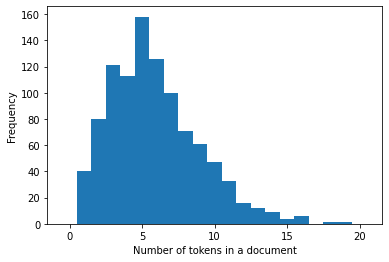

In [19]:
plt.hist(number_of_tokens, bins=np.arange(max(number_of_tokens)+1) - 0.5)
plt.xlabel('Number of tokens in a document')
plt.ylabel('Frequency')
plt.show()

## Classification

### Feature matrix generation

The first step is to convert the textual data to numeric values by counting the number of times a token appears in each document. Stop words are ignored because they are deemed 'noise' and don't provide information as to which topic a text contains.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
# Tokenise, remove stop words and count token occurrences
vectorizer = CountVectorizer(stop_words=list(stop_words))

In [22]:
counts = vectorizer.fit_transform(texts)
print(f"counts shape = {counts.shape}")

y = class_labels
print(f"y shape = {y.shape}")

counts shape = (1000, 818)
y shape = (1000, 3)


In [23]:
# Check the number of rows
assert counts.shape[0] == n_documents

# Check none of the stop words have been counted
assert len(set(vectorizer.get_feature_names()).intersection(stop_words)) == 0

# Check the shape of the labels
assert y.shape[0] == n_documents
assert y.shape[1] == len(class_words)

The counts are normalised by converting the values to TF-IDF scores.

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

In [25]:
# Convert the counts to TF-IDF scores
transformer = TfidfTransformer(smooth_idf=False)
X = transformer.fit_transform(counts)
print(f"X shape = {X.shape}")

X shape = (1000, 818)


### Split data into test and training sets

The feature matrix and class matrix are together now divided into training and test sets. The training set will be used for training the classifiers. The test set will only be used at the end to measure the performance of the chosen classifer. The performance on the test set gives an indication as to how well the classifier will work on unseen data provided it is sufficiently similar to the training data.

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Initial classifier selection

In this section a range of multilabel classifiers are checked to see whether they show promising performance.

#### k-Nearest neighbour classifier

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier

In [29]:
knn_clf = KNeighborsClassifier()
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

In [30]:
f1_score(y_train, y_train_knn_pred, average="macro")

0.005148005148005148

#### Decision tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
dt_clf = DecisionTreeClassifier()
y_train_dt_pred = cross_val_predict(dt_clf, X_train, y_train, cv=3)

In [33]:
f1_score(y_train, y_train_dt_pred, average="macro")

0.7382939468829038

#### Random forests

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rf_clf = RandomForestClassifier(max_depth=10)

In [36]:
y_train_rf_pred = cross_val_predict(rf_clf, X_train, y_train, cv=3)

In [37]:
f1_score(y_train, y_train_rf_pred, average="macro")

0.2868271402975773

### Classifier tuning

The most promising classifier from the previous section is now tuned by performing a parameter search.

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
dt_clf = DecisionTreeClassifier()

In [40]:
param_grid = [
    {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [6, 8, 10, 12, 14, 18, 20, None]
    }
]

In [41]:
grid_search = GridSearchCV(dt_clf, param_grid, cv=3,
                           scoring='neg_mean_squared_error')

In [42]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [6, 8, 10, 12, 14, 18, 20, None],
                          'splitter': ['best', 'random']}],
             scoring='neg_mean_squared_error')

In [43]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': None, 'splitter': 'random'}

In [44]:
grid_search.best_estimator_.get_depth()

59

In [45]:
# Perform cross-validation using the best estimator
y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred, average='macro')}")
print(f"Recall: {recall_score(y_train, y_train_pred, average='macro')}")
print(f"f1-score: {f1_score(y_train, y_train_pred, average='macro')}")

Precision: 0.9073672566371681
Recall: 0.649256086002195
f1-score: 0.746911663216011


### Feature selection

Now that the optimal classifier has been determined from the possible classifiers given the range of parameters, the features that should be used are now selected.

In [46]:
from sklearn.feature_selection import SelectFromModel

In [47]:
# The estimator produces scores for the features
grid_search.best_estimator_.feature_importances_[:20]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01418693, 0.        ,
       0.        , 0.00211167, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [48]:
# Select the features based on the model
model = SelectFromModel(grid_search.best_estimator_, prefit=True)

In [49]:
X_train

<670x818 sparse matrix of type '<class 'numpy.float64'>'
	with 2530 stored elements in Compressed Sparse Row format>

In [50]:
# Note how the number of features is reduced by this selection phase
X_train_fs = model.transform(X_train)
X_train_fs

<670x84 sparse matrix of type '<class 'numpy.float64'>'
	with 903 stored elements in Compressed Sparse Row format>

### Optimal classifier given the selected features

In [51]:
# A grid search is now performed again, this time with the training data with the
# reduced set of features
dt_clf = DecisionTreeClassifier()

param_grid = [
    {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [6, 8, 10, 12, 14, 18, 20, None]
    }
]

grid_search = GridSearchCV(dt_clf, param_grid, cv=3,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train_fs, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [6, 8, 10, 12, 14, 18, 20, None],
                          'splitter': ['best', 'random']}],
             scoring='neg_mean_squared_error')

In [52]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': None, 'splitter': 'random'}

In [53]:
grid_search.best_estimator_.get_depth()

59

In [54]:
# Perform cross-validation using the best estimator
y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train_fs, y_train, cv=3)

print(f"Precision: {precision_score(y_train, y_train_pred, average='macro')}")
print(f"Recall: {recall_score(y_train, y_train_pred, average='macro')}")
print(f"f1-score: {f1_score(y_train, y_train_pred, average='macro')}")

Precision: 0.9069306930693068
Recall: 0.7321385812630948
f1-score: 0.8097936856626031


## Final performance measure on held-out test set

In this section the performance of the chosen classifier on the held-out test set is determined.

In [55]:
# Retain the selected features
X_test_fs = model.transform(X_test)
X_test_fs

<330x84 sparse matrix of type '<class 'numpy.float64'>'
	with 426 stored elements in Compressed Sparse Row format>

In [56]:
# Train the classifier using all of the available training data
grid_search.best_estimator_.fit(X_train_fs, y_train)

# Predict the labels based on the test data set's feature matrix
y_pred = grid_search.best_estimator_.predict(X_test_fs)

# Measure the performance of the classifier on the test set
f1_score(y_test, y_pred, average="macro")

0.7423899319279754

In [57]:
precision_score(y_test, y_pred, average="macro")

0.9134615384615384

In [58]:
recall_score(y_test, y_pred, average="macro")

0.6392216548834774